In [1]:
import os
import zipfile
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# # --- UNZIP DATASET ---
# # --- UNZIP DATASET ---
# dataset_zip = 'data_final.zip'
# if not os.path.exists('data_final'):
#     with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
#         zip_ref.extractall('data_final.zip')

# --- PARAMETERS ---
IMG_SIZE = (224, 224)
CLASSES = [chr(i) for i in range(ord('A'), ord('Z')+1)]

# --- UTILITY: LOAD & CROP DATA ---
def load_dataset(image_dir):
    images, labels = [], []
    i = 0
    for img_path in glob.glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True):
        i+=1
        xml_path = os.path.splitext(img_path)[0] + '.xml'
        if not os.path.exists(xml_path):
            continue
        try:
            tree = ET.parse(xml_path)
            obj = tree.find('.//object')
            label = obj.find('name').text.strip().upper()
            if label not in CLASSES:
                continue
            b = obj.find('bndbox')
            xmin, ymin = int(b.find('xmin').text), int(b.find('ymin').text)
            xmax, ymax = int(b.find('xmax').text), int(b.find('ymax').text)
        except Exception:
            continue
        img = Image.open(img_path).convert('RGB').crop((xmin, ymin, xmax, ymax)).resize(IMG_SIZE)
        if (i < 20):
            img.save(f"cropped_sample{i}.jpg")


        arr = np.array(img)
        arr = tf.keras.applications.efficientnet.preprocess_input(arr)
        images.append(arr)
        labels.append(CLASSES.index(label))
    X = np.expand_dims(np.array(images), axis=1)
    y = to_categorical(labels, num_classes=len(CLASSES))
    return X, y

# Load & split
dir_path = 'data'
X, y = load_dataset(dir_path)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Compute class weights
y_indices = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight('balanced', classes=np.arange(len(CLASSES)), y=y_indices)
class_weights = dict(enumerate(weights))

# --- MODEL BUILDING ---
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

# Use EfficientNetB0 for a lighter model
efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
efficientnet.trainable = False

inp = Input((1,224,224,3))
x = TimeDistributed(efficientnet)(inp)
x = TimeDistributed(GlobalAveragePooling2D())(x)
# L2 regularization on LSTM
x = LSTM(128, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4))(x)
x = Dropout(0.6)(x)
# L2 reg on final Dense
out = Dense(len(CLASSES), activation='softmax', kernel_regularizer=l2(1e-4))(x)
model = Model(inp, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


checkpoint_head = ModelCheckpoint('best_head.h5', save_best_only=True, monitor='val_accuracy')
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
# --- TRAINING HEAD ---
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[checkpoint_head, early_stop]
)



checkpoint_ft = ModelCheckpoint('best_finetune.h5', save_best_only=True, monitor='val_accuracy')
early_stop2 = EarlyStopping(patience=25, restore_best_weights=True)  # increased patience to allow more fine-tuning epochs
# --- FINE-TUNE BACKBONE ---
# Unfreeze last blocks of EfficientNetB0 (block4-6)
for layer in efficientnet.layers:
    if any(block in layer.name for block in ['block4', 'block5', 'block6']):
        layer.trainable = True
    else:
        layer.trainable = False

# Lower LR for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[checkpoint_ft, early_stop2]
)

# --- SAVE ---
model.save('model_refined_b0.h5')
print("Training complete. Model saved as EfficientNetB0-based.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 224, 224, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 7, 7, 1280)  │     4,049,571 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 1280)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,774,333 (18.21 MB)

 Trainable params: 724,762 (2.76 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/8
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.0897 - loss: 3.2717

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step - accuracy: 0.0951 - loss: 3.2631 - val_accuracy: 0.5684 - val_loss: 2.8223
Epoch 2/8
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3728 - loss: 2.6968

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.3800 - loss: 2.6792 - val_accuracy: 0.8034 - val_loss: 2.0208
Epoch 3/8
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6069 - loss: 1.9594

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - accuracy: 0.6093 - loss: 1.9446 - val_accuracy: 0.8803 - val_loss: 1.3452
Epoch 4/8
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7775 - loss: 1.3302

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - accuracy: 0.7785 - loss: 1.3223 - val_accuracy: 0.9231 - val_loss: 0.9283
Epoch 5/8
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8588 - loss: 0.9895

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.8607 - loss: 0.9825 - val_accuracy: 0.9658 - val_loss: 0.6937
Epoch 6/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.9323 - loss: 0.7013 - val_accuracy: 0.9615 - val_loss: 0.5441
Epoch 7/8
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9181 - loss: 0.6129

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.9192 - loss: 0.6099 - val_accuracy: 0.9786 - val_loss: 0.4635
Epoch 8/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.9593 - loss: 0.5152 - val_accuracy: 0.9615 - val_loss: 0.3946
Epoch 1/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3997 - loss: 2.3534

35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 297ms/step - accuracy: 0.3997 - loss: 2.3527 - val_accuracy: 0.9530 - val_loss: 0.4000
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.4518 - loss: 2.1876 - val_accuracy: 0.9231 - val_loss: 0.5230
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.5285 - loss: 1.9286 - val_accuracy: 0.9060 - val_loss: 0.6559
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.5879 - loss: 1.7803 - val_accuracy: 0.8803 - val_loss: 0.7458
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.6624 - loss: 1.6054 - val_accuracy: 0.8761 - val_loss: 0.7935
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.7060 - loss: 1.4272 - val_accuracy: 0.8974 - val_loss: 0.7983
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.7274 - loss: 1.3051 - val_accuracy: 0.9017 - val_loss: 0.7823
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.7445 - loss: 1.2222 - val_accuracy: 0.9188 - val

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.8923 - loss: 0.8004 - val_accuracy: 0.9573 - val_loss: 0.5553
Epoch 14/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9004 - loss: 0.7061

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.9009 - loss: 0.7050 - val_accuracy: 0.9658 - val_loss: 0.5185
Epoch 15/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9205 - loss: 0.6491 - val_accuracy: 0.9658 - val_loss: 0.4873
Epoch 16/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9301 - loss: 0.6006

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.9301 - loss: 0.6004 - val_accuracy: 0.9701 - val_loss: 0.4584
Epoch 17/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.9427 - loss: 0.5812 - val_accuracy: 0.9658 - val_loss: 0.4351
Epoch 18/25
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9481 - loss: 0.5826

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.9477 - loss: 0.5817 - val_accuracy: 0.9744 - val_loss: 0.4111
Epoch 19/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9497 - loss: 0.5289

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.9494 - loss: 0.5289 - val_accuracy: 0.9786 - val_loss: 0.3917
Epoch 20/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.9440 - loss: 0.5104 - val_accuracy: 0.9786 - val_loss: 0.3734
Epoch 21/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9533 - loss: 0.4692

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - accuracy: 0.9532 - loss: 0.4697 - val_accuracy: 0.9829 - val_loss: 0.3574
Epoch 22/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.9694 - loss: 0.4443 - val_accuracy: 0.9829 - val_loss: 0.3407
Epoch 23/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.9574 - loss: 0.4433 - val_accuracy: 0.9829 - val_loss: 0.3261
Epoch 24/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.9731 - loss: 0.4313 - val_accuracy: 0.9829 - val_loss: 0.3147
Epoch 25/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.9663 - loss: 0.4202 - val_accuracy: 0.9829 - val_loss: 0.3038


Training complete. Model saved as EfficientNetB0-based.


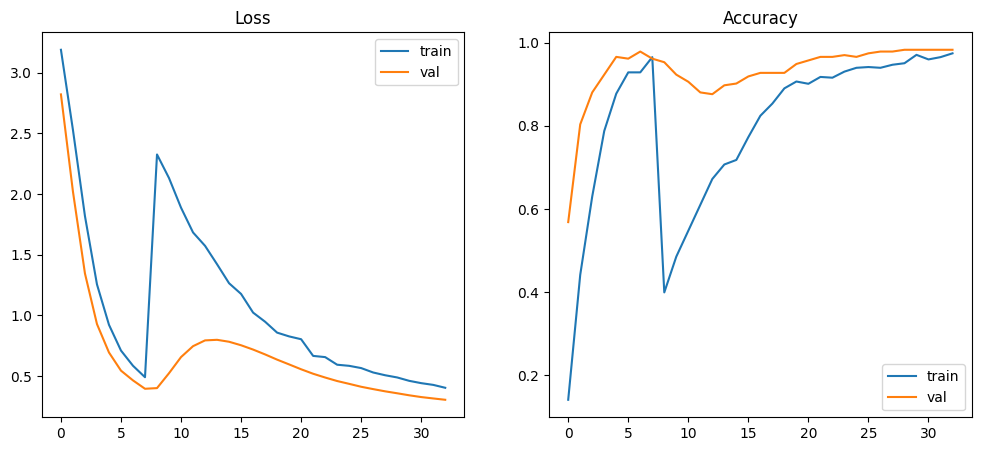

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history1.history['loss'] + history2.history['loss'], label='train')
plt.plot(history1.history['val_loss'] + history2.history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'] + history2.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend()
plt.savefig('training_curves.png')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step


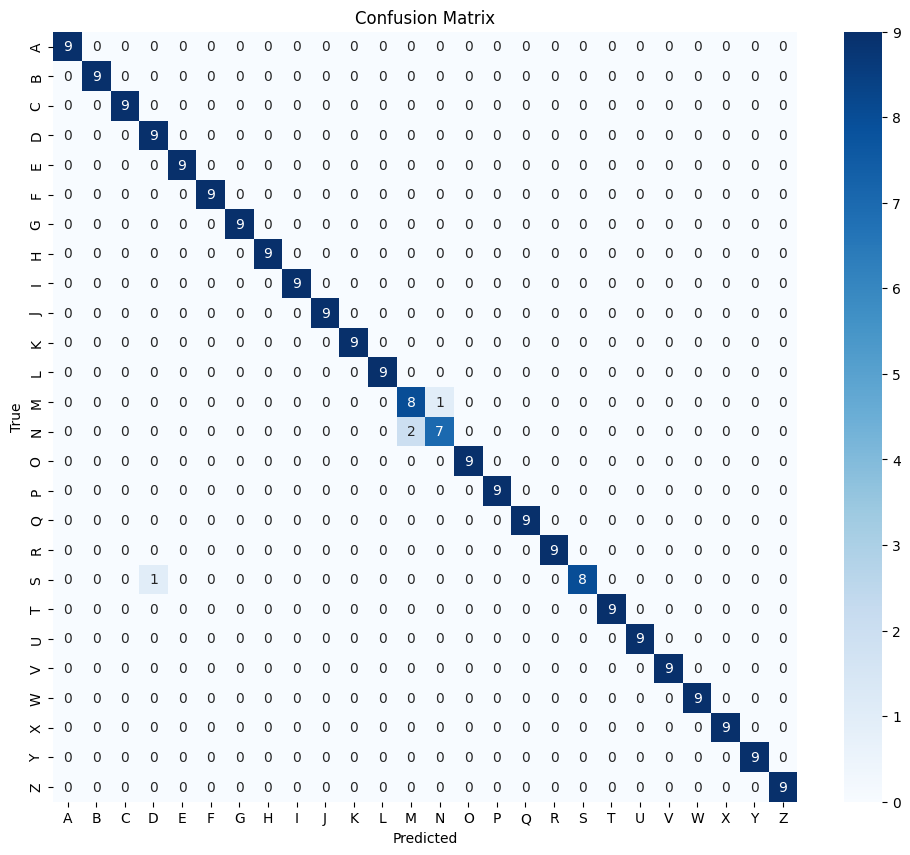

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Predict on validation set ---
y_val_true = np.argmax(y_val, axis=1)  # convert one-hot to class indices
y_val_pred = model.predict(X_val)
y_val_pred_idx = np.argmax(y_val_pred, axis=1)

# --- Compute confusion matrix ---
cm = confusion_matrix(y_val_true, y_val_pred_idx)

# --- Plot confusion matrix ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [4]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get true and predicted class indices
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)

# Build confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Compute per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Print per-class accuracy
for idx, acc in enumerate(per_class_acc):
    print(f"Class {CLASSES[idx]}: {acc:.2%} accuracy")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step
Class A: 100.00% accuracy
Class B: 100.00% accuracy
Class C: 100.00% accuracy
Class D: 100.00% accuracy
Class E: 100.00% accuracy
Class F: 100.00% accuracy
Class G: 100.00% accuracy
Class H: 100.00% accuracy
Class I: 100.00% accuracy
Class J: 100.00% accuracy
Class K: 100.00% accuracy
Class L: 100.00% accuracy
Class M: 88.89% accuracy
Class N: 77.78% accuracy
Class O: 100.00% accuracy
Class P: 100.00% accuracy
Class Q: 100.00% accuracy
Class R: 100.00% accuracy
Class S: 88.89% accuracy
Class T: 100.00% accuracy
Class U: 100.00% accuracy
Class V: 100.00% accuracy
Class W: 100.00% accuracy
Class X: 100.00% accuracy
Class Y: 100.00% accuracy
Class Z: 100.00% accuracy


In [5]:
from sklearn.metrics import classification_report
import numpy as np

# --- MAKE PREDICTIONS ---
# Predict using the trained model on the validation set
y_pred = model.predict(X_val)

# Convert the one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# --- CLASSIFICATION REPORT ---
report = classification_report(y_val_true, y_val_pred_idx)
print(report)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       0.90      1.00      0.95         9
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00         9
          12       0.80      0.89      0.84         9
          13       0.88      0.78      0.82         9
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         9
          16       1.00      1.00      1.0

In [8]:
model.save('Newest_model_refined_b0.h5')
print("Training complete. Model saved as EfficientNetB0-based.")

Training complete. Model saved as EfficientNetB0-based.


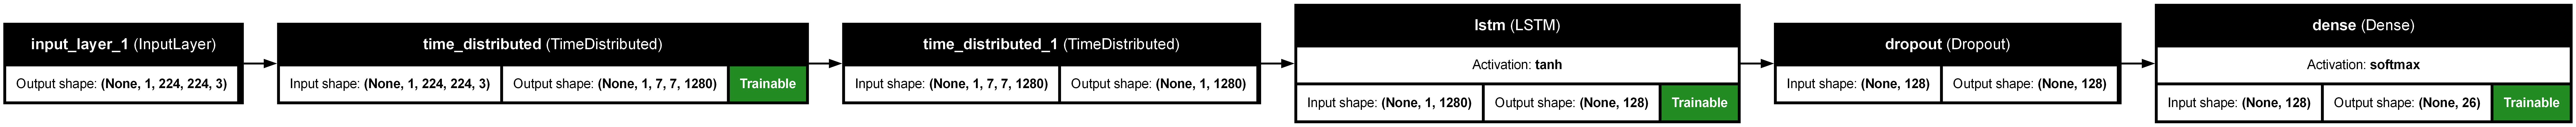

In [1]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

# Load CNN-LSTM model,
MODEL_PATH = 'Newest_model_refined_b0.h5'
model = load_model(MODEL_PATH)

# keras.utils.model_to_dot(
#     model,
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=200,
#     subgraph=False,
#     show_layer_activations=False,
#     show_trainable=False,
#     **kwargs
# )
# # Save the model architecture diagram,


plot_model(
    model,
    to_file="model.png",
    show_shapes=True,            # Show input/output shapes
    show_dtype=False,
    show_layer_names=True,       # Show names for clarity
    rankdir="LR",                # Left-to-right layout (more readable for hybrid models)
    expand_nested=True,          # Expand nested models/layers
    dpi=300,                     # Higher resolution
    show_layer_activations=True, # Show activation functions
    show_trainable=True          # Indicate trainable layers
)